## Descriptors-based regression

## 1. Using SIFT descriptors

<p style="font-family: sans-serif; font-size: 16px;">
References: <br><br>
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html <br><br>
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html <br>
</p>

In [1]:
import sys
import os
import random

sys.path.append(os.getcwd() + '/..')
sys.path.append(os.getcwd() + '/../..')

In [2]:
from get_data import load_data, load_label, fetch_particular_series, plot_series, load_particular_label

In [3]:
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj
import cv2
from skimage import data, transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

import cv2
import numpy as np

In [4]:
img1 = fetch_particular_series("009988", 1, data_directory="../../data/images/", grayscale=True)
img2 = fetch_particular_series("009988", 2, data_directory="../../data/images/", grayscale=True)

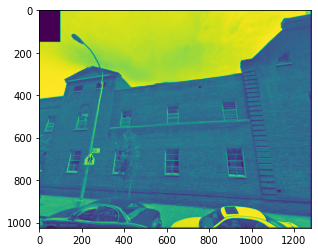

In [5]:
plt.imshow(img1.astype(np.uint8))

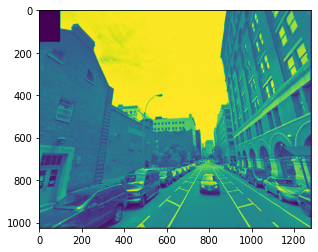

In [6]:
plt.imshow(img2.astype(np.uint8))

In [7]:
# from scikit-image - we will use OpenCV's implementation instead (faster)
# descriptor_extractor = SIFT() 

In [19]:
# from OpenCV - better since we can limit the number of descriptors - gain exec. time
descriptor_extractor = cv2.xfeatures2d.SIFT_create(nfeatures=1000)

In [8]:
# scikit-image's way to getting keypoints and descriptors - not used thereafter (just for reference)
# descriptor_extractor.detect_and_extract(img1)
# keypoints_img1 = descriptor_extractor.keypoints
# descriptors_img1 = descriptor_extractor.descriptors

In [20]:
keypoints_img1, descriptors_img1 = descriptor_extractor.detectAndCompute(img1, None)

In [21]:
print(f"Nombre de point-clés trouvés : {len(keypoints_img1)}\n Nombre de descripteurs trouvés : {len(descriptors_img1)}")

Nombre de point-clés trouvés : 1000
 Nombre de descripteurs trouvés : 1000


Remarque : on constate que la limitation à une centaine de descripteurs a fonctionné.

In [22]:
keypoints_img2, descriptors_img2 = descriptor_extractor.detectAndCompute(img2, None)

In [23]:
# we will use OpenCV's BFMatcher (stand for Brute-Force Matcher) to compute matches among descriptors
bf = cv2.BFMatcher()
# matches will be computed using k-Nearest Neighbors method in the descriptors' space
matches = bf.knnMatch(descriptors_img1, descriptors_img2, k=2)

In [ ]:
# just for reference - scikit-image's way of computing matches is the following:
# matches = match_descriptors(descriptors_img1,
#                             descriptors_img2,
#                             max_ratio=0.6,
#                             cross_check=True)

In [25]:
# filter good matches
good = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

In [26]:
res = cv2.drawMatchesKnn(img1, keypoints_img1, img2, keypoints_img2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

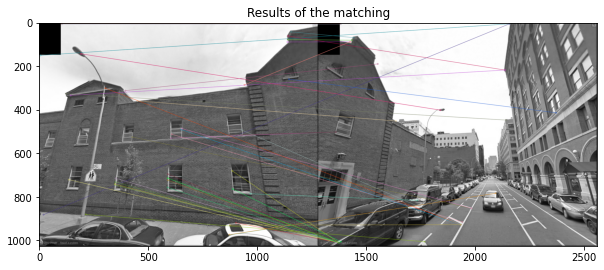

In [27]:
plt.figure(figsize=(10, 10))
plt.title("Results of the matching")
plt.imshow(res)
plt.show()

In [25]:
# the following ligns are only relevant when using scikit-image's SIFT implementation (comparison of un-restricted and restricted # of matches)
# print("Nombre de match version full :", len(matches))
# print("Nombre de match version short :", len(matches_short))
# print("Ratio nombre de descripteurs total/nombre de match pour la version full : {}%".format(round(100*len(matches)/len(descriptors_img1), 2)))
# print("Ratio nombre de descripteurs total/nombre de match pour la version short : {}%".format(round(100*len(matches_short)/len(descriptors_img1_short), 2)))

Nombre de match version full : 67
Nombre de match version short : 19
Ratio nombre de descripteurs total/nombre de match pour la version full : 0.88%
Ratio nombre de descripteurs total/nombre de match pour la version short : 19.0%


In [28]:
print("Nombre de match total version OpenCV :", len(matches))
print("Nombre de match filtrés version OpenCV :", len(good))
print("Ratio nombre de descripteurs total/nombre de match : {}%".format(round(100*len(good)/len(descriptors_img1), 2)))

Nombre de match total version OpenCV : 1000
Nombre de match filtrés version OpenCV : 46
Ratio nombre de descripteurs total/nombre de match : 4.6%


In [30]:
nb_matches = len(matches)

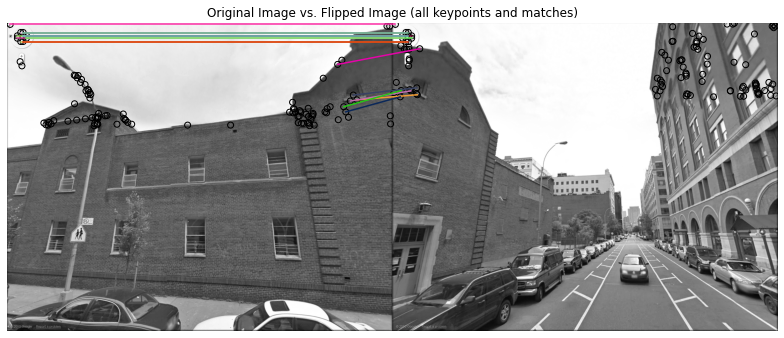

In [38]:
# when using scikit-image's SIFT - for plotting results
# fig, ax = plt.subplots(1, 1, figsize=(11, 8))
# plt.gray()
# plot_matches(ax, img1, img2, keypoints_img1, keypoints_img2, matches)
# ax.axis('off')
# ax.set_title("Original Image vs. Flipped Image (all keypoints and matches)")
# plt.tight_layout()
# plt.show()

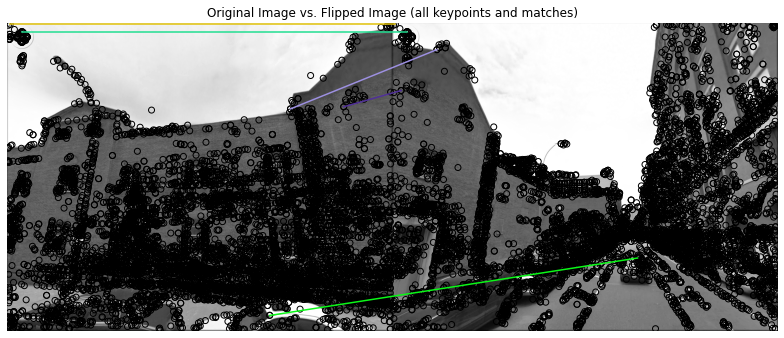

In [ ]:
# when using scikit-image's SIFT - for plotting results
# fig, ax = plt.subplots(1, 1, figsize=(11, 8))
# plt.gray()
# plot_matches(ax, img1, img2, keypoints_img1, keypoints_img2, matches[::15])
# ax.axis('off')
# ax.set_title("Original Image vs. Flipped Image (short version)")
# plt.tight_layout()
# plt.show()

Conclusion: need to crop images so as to prevent matches between the pad arrows! 
May be possible to detect close images based on SIFT descriptors using a retrieval approach. 

## 2. Towards descriptors-retrieval based regression

In [4]:
# start by creating a base of descriptors-label
def create_database_opencv(ids_in_database: list = ["009900", "009902", "009992", "009994", "010207"], nb_descriptors: int = 100):
    """
    Create a mapping between descriptors and labels (Cartesian coordinates).
    """
    descriptor_extractor = cv2.xfeatures2d.SIFT_create(nfeatures=nb_descriptors)
    database_ids = ids_in_database
    database = {}
    count = 1
    for image_id in database_ids:
        print(f"Creating database: {count}/{len(database_ids)}")
        img = fetch_particular_series(image_id, 1, data_directory="../../data/images/", grayscale=True)
        keypoints, descriptors = descriptor_extractor.detectAndCompute(img, None)
        (x, y, _) = load_particular_label(image_id, path = "../../data/labels.mat")
        database[(x, y)] = descriptors
        count += 1
    return database

In [51]:
# scikit-image version
# def create_database(ids_in_database: list = ["009900", "009902", "009992", "009994", "010207"], nb_descriptors: int = 100):
#     """
#     Create a mapping between descriptors and labels (Cartesian coordinates).
#     """
#     descriptor_extractor = SIFT()
#     database_ids = ids_in_database
#     database = {}
#     count = 1
#     for image_id in database_ids:
#         print(f"Creating database: {count}/{len(database_ids)}")
#         img = fetch_particular_series(image_id, 1, data_directory="../../data/images/", grayscale=True)
#         descriptor_extractor.detect_and_extract(img)
#         descriptors = descriptor_extractor.descriptors[:nb_descriptors]
#         (x, y, _) = load_particular_label(image_id, path = "../../data/labels.mat")
#         key = "(" + str(x) + "," + str(y) + ")"
#         database[key] = descriptors
#         count += 1
#     return database

In [30]:
def infer_image_cartesian_coordinates(inference_image, database: dict, nb_descriptors: int = 100, thresh: float = 0.75):
    """ 
    Run inference with descriptors-based retrieval regression.
    """
    initial_location = (0.0, 0.0)
    average_x_coord, average_y_coord = [], []
    descriptor_extractor = cv2.xfeatures2d.SIFT_create(nfeatures=nb_descriptors)
    inference_keypoints, inference_descriptors = descriptor_extractor.detectAndCompute(inference_image, None)
    bf = cv2.BFMatcher()

    for location, descriptors in database.items():    
        matches = bf.knnMatch(descriptors, inference_descriptors, k=2)
        # filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < thresh*n.distance:
                good_matches.append([m])
        # only good matches/filtered matches matter!
        nb_matches = len(good_matches)
        for i in range(nb_matches):
            # pondération par le nombre de matchs
            average_x_coord.append(location[0])
            average_y_coord.append(location[1])
    x_infer = np.mean(average_x_coord)
    y_infer = np.mean(average_y_coord)
    if (x_infer is None) or (y_infer is None):
        return initial_location
    else:
        return (x_infer, y_infer)

In [59]:
# scikit-image version
# def infer_image_cartesian_coordinates(inference_image, database: dict):
#     """ 
#     Run inference with descriptors-based retrieval regression.
#     """
#     initial_location = (0.0, 0.0)
#     average_x_coord, average_y_coord = [], []
#     descriptor_extractor = SIFT()
#     descriptor_extractor.detect_and_extract(inference_image)
#     inference_descriptors = descriptor_extractor.descriptors
#     for location, descriptors in database.items():
#         matches = match_descriptors(descriptors,
#                                 inference_descriptors,
#                                 max_ratio=0.6,
#                                 cross_check=True)
#         nb_matches = len(matches)
#         for i in range(nb_matches):
#             # pondération par le nombre de matchs
#             average_x_coord.append(location[0])
#             average_y_coord.append(location[1])

#     x_infer = np.mean(average_x_coord)
#     y_infer = np.mean(average_y_coord)
#     if (x_infer is None) or (y_infer is None):
#         return initial_location
#     else:
#         return (x_infer, y_infer)

In [41]:
database = create_database_opencv()

Creating database: 1/5
Creating database: 2/5
Creating database: 3/5
Creating database: 4/5
Creating database: 5/5


In [42]:
database.keys()

dict_keys([(40.743143, -74.008754), (40.743285, -74.008726), (40.733099, -74.007463), (40.733307, -74.007414), (40.717808, -74.005696)])

In [43]:
# try inference
inference_id = "009993"
image_inference = fetch_particular_series(inference_id, 1, data_directory="../../data/images/", grayscale=True)
(x_true, y_true, _) = load_particular_label(inference_id, path = "../../data/labels.mat")
(x_infer, y_infer) = infer_image_cartesian_coordinates(image_inference, database)

[40.733307, 40.733307, 40.717808]


In [44]:
# évaluation de la performance
print(f"x_true: {x_true}, y_true: {y_true}")
print(f"x_infer: {x_infer}, y_infer: {y_infer}")

x_true: 40.73319, y_true: -74.007441
x_infer: 40.72814066666667, y_infer: -74.00684133333333


In [7]:
def compute_distance(coord_infer: tuple, coord_true: tuple):
    """
    Compute the Cartesian distance between the infered and true coordinates.
    """
    inProj = Proj(init='epsg:4326') # (lat, long)
    outProj = Proj(init='epsg:2154') # Lambert 93
    x1, y1 = 882408.3,6543019.6
    x_true_l93, y_true_l93 = pyproj.transform(inProj, outProj, x_true, y_true)
    x_infer_l93, y_infer_l93 = pyproj.transform(inProj, outProj, x_infer, y_infer)
    dist = np.sqrt(
        (x_true_l93 - x_infer_l93)**2 + (y_true_l93 - y_infer_l93)**2
    )
    # print(f"Cartesian distance: {round(dist, 1)} meters.")
    return dist

In [46]:
dist = compute_distance((x_infer, y_infer), (x_true, y_true))

C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_13108\3024225497.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-

Cartesian distance: 3384.2 meters.


C:\Users\cleme\AppData\Local\Temp\ipykernel_13108\3024225497.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_infer_l93, y_infer_l93 = pyproj.transform(inProj, outProj, x_infer, y_infer)


Conclusion : construire la base de données est très coûteux en temps et la comparaison des descripteurs pour l'inférence est très coûteuse en temps également mais la solution semble au final bien fonctionner.

## 3. Evaluting the model on the problem's data

In [8]:
# on commence par couper le jeu de données en train, test (pas de validation car pas de sélection d'hyperparamètres)
all_filenames = os.listdir("../../data/images")
all_ids = list(set([item.split("_")[0] for item in all_filenames]))
all_ids = all_ids
N = len(all_ids)
# shuffle IDs
random.shuffle(all_ids)
# 20% des données pour le test, 80% pour constituer la base de données
train_test_ratio = 0.9
X_train_ids = all_ids[:int(train_test_ratio*N)]
X_test_ids = all_ids[int(train_test_ratio*N):]
print(len(X_train_ids))
print(len(X_test_ids)) 

399
45


In [31]:
database = create_database_opencv(X_train_ids, nb_descriptors=1000)

Creating database: 1/399
Creating database: 2/399
Creating database: 3/399
Creating database: 4/399
Creating database: 5/399
Creating database: 6/399
Creating database: 7/399
Creating database: 8/399
Creating database: 9/399
Creating database: 10/399
Creating database: 11/399
Creating database: 12/399
Creating database: 13/399
Creating database: 14/399
Creating database: 15/399
Creating database: 16/399
Creating database: 17/399
Creating database: 18/399
Creating database: 19/399
Creating database: 20/399
Creating database: 21/399
Creating database: 22/399
Creating database: 23/399
Creating database: 24/399
Creating database: 25/399
Creating database: 26/399
Creating database: 27/399
Creating database: 28/399
Creating database: 29/399
Creating database: 30/399
Creating database: 31/399
Creating database: 32/399
Creating database: 33/399
Creating database: 34/399
Creating database: 35/399
Creating database: 36/399
Creating database: 37/399
Creating database: 38/399
Creating database: 39

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
# run inference and compute the average losse
losses = []
count = 1
for inference_id in X_test_ids:
    print(f"Count: {count}/{len(X_test_ids)}")
    image_inference = fetch_particular_series(inference_id, 1, data_directory="../../data/images/", grayscale=True)
    (x_true, y_true, _) = load_particular_label(inference_id, path = "../../data/labels.mat")
    (x_infer, y_infer) = infer_image_cartesian_coordinates(image_inference, database, thresh=0.4)
    dist = compute_distance((x_infer, y_infer), (x_true, y_true))
    losses.append(dist)
    count += 1

Count: 1/45
Count: 2/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Count: 3/45
Count: 4/45
Count: 5/45
Count: 6/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Count: 7/45
Count: 8/45
Count: 9/45
Count: 10/45
Count: 11/45
Count: 12/45
Count: 13/45
Count: 14/45
Count: 15/45
Count: 16/45
Count: 17/45
Count: 18/45
Count: 19/45
Count: 20/45
Count: 21/45
Count: 22/45
Count: 23/45
Count: 24/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Count: 25/45
Count: 26/45
Count: 27/45
Count: 28/45
Count: 29/45
Count: 30/45
Count: 31/45
Count: 32/45
Count: 33/45
Count: 34/45
Count: 35/45
Count: 36/45
Count: 37/45
Count: 38/45
Count: 39/45
Count: 40/45
Count: 41/45
Count: 42/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Count: 43/45
Count: 44/45


In [42]:
average_loss = np.mean(losses)
print("Average loss (in meters) for the descriptors-based retrieval regression method: {} meters.".format(round(average_loss, 2)))

Average loss (in meters) for the descriptors-based retrieval regression method: nan meters.


In [40]:
DUMMY_LOSS = 8334 # average error in meters of the dummy regression (see baseline-model)
print("The descriptors-based retrieval regression method outperforms the dummy regression by {}%".format(
    round(100*(DUMMY_LOSS - average_loss)/DUMMY_LOSS, 2)
))

The descriptors-based retrieval regression method outperforms the dummy regression by 18.79%
